# City Facilities Data Cleaning and Analysis

For this section, we'll be analyzing city facility data at large in SF using the `data/raw/City_Facilities_20251109.geojson` file. First, I'll begin by importing the necessary dependencies and loading the city facility data as well as the census tract data for mainland San Franciso.

In [94]:
# import necessary dependencies 
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.express as px
from census import Census
from us import states
import os
from pathlib import Path
from IPython.display import display
import seaborn as sns
import re
import zipfile
from shapely.geometry import Point
import folium
import seaborn as sns
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import matplotlib as mpl

# set general seaborn style
sns.set_theme(style="whitegrid", font_scale=1.1)

In [95]:
# use robust path handling to locate the data file
def find_repo_root(start: Path = Path.cwd()) -> Path:
    for p in [start] + list(start.parents):
        if (p / 'requirements.txt').exists() or (p / '.git').exists():
            return p
    return start

repo_root = find_repo_root()
data_file = repo_root / 'data' / 'raw' / 'City_Facilities_20251109.geojson'

if not data_file.exists():
    raise FileNotFoundError(f"Data file not found at {data_file}. Check the file name and data/raw folder.")

# load the data from the data/raw folder
city_facilities_df = gpd.read_file(data_file, engine="pyogrio") # was having issue with fiona engine (so switching to pyogrio)

In [96]:
# load and extract SF census tracts shapefile
zip_path = repo_root / "data" / "raw" / "tl_2023_06_tract.zip"
out_dir = repo_root / "data" / "raw" / "tracts"

if not out_dir.exists():
    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extractall(out_dir)

#  find shapefile inside extracted folder
tract_path = next(out_dir.glob("*.shp"), None)
if tract_path is None:
    raise FileNotFoundError("No .shp file found after extraction. Check the zip contents.")

# load shapefile using pyogrio for speed 
tracts = gpd.read_file(tract_path, engine="pyogrio")

# filter to SF County only (FIPS 075) 
sf_tracts = tracts[tracts["COUNTYFP"] == "075"].copy()

# filter to mainland SF (remove the Farallon Islands)
sf_tracts = sf_tracts.cx[-122.55:-122.35, 37.70:37.84]

# testing the SF boundary plot
# sf_tracts.boundary.plot();

#### Initial Look at the Raw Data via Visualizations

I'm interested in seeing how the different cateogories of amenities as described by our research report pdf is spread across San Francisco (like tracts in SF). In the `city_facilities_df`, there is a `department_name` column that gives some insight into this distribution, which works out as a great starting point.

In [97]:
# explore department_name values
city_facilities_df["department_name"].value_counts().head(10)

department_name
Recreation And Parks               570
Port                               213
School District (Sfusd)            156
Municipal Transportation Agency    127
Non-City                           126
Airport (Sfo)                      116
Public Utilities Commission        100
Fire Department                     57
Gsa - Real Estate Division          57
Public Health                       42
Name: count, dtype: int64

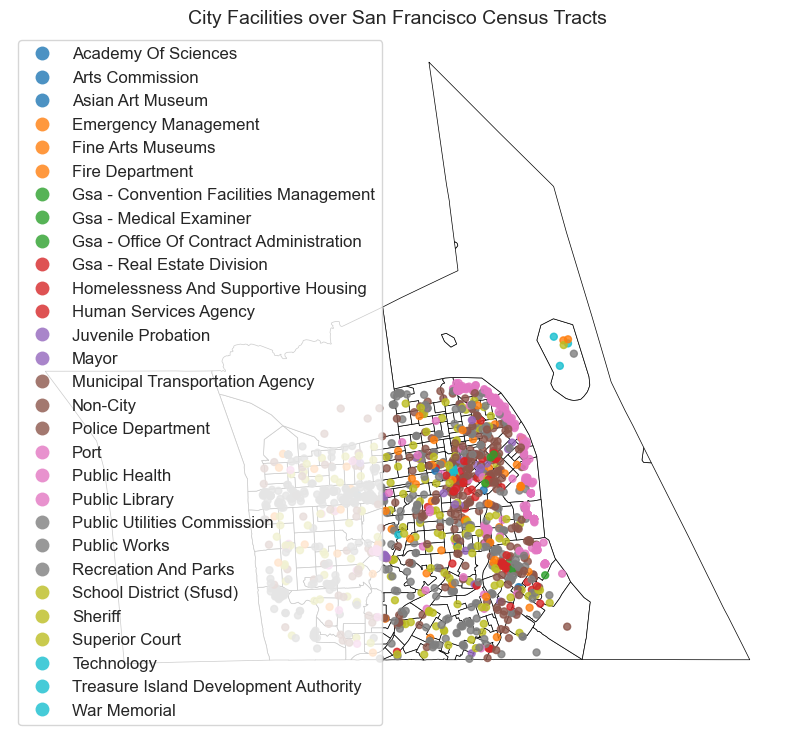

In [98]:
# make sure both are using the same coordinate reference system
city_facilities = city_facilities_df.to_crs(sf_tracts.crs)

# spatial join to find city facilities within SF census tracts 
city_facilities_sf = gpd.sjoin(city_facilities, sf_tracts, how="inner", predicate="within")

# plot
fig, ax = plt.subplots(figsize=(10, 10))
sf_tracts.plot(ax=ax, color='white', edgecolor='black', linewidth=0.5)
city_facilities_sf.plot(
    ax=ax,
    column="department_name",   # color by department
    categorical=True,
    legend=True,
    markersize=25,
    alpha=0.8,
)

# pptional styling
ax.set_title("City Facilities over San Francisco Census Tracts", fontsize=14)
ax.set_axis_off()
plt.show()

There are many categories under `department_name` which may not all be the most informative to our project, so I'll focus on highlighting the 5 main amenity categories, we want to focus on. Additionally, there are things I can do to improve the visual quality of the visualization by denoting what is land vs. water, using an interactive map via explore, and effective color schemes.

Here are some additions and changes I'll do to the data before the next visualization:

In [99]:
# create mapping from department_name to amenity category
amenity_map = {
    # recreational
    "Recreation And Parks": "Recreational",
    "Fine Arts Museums": "Recreational",
    "Arts Commission": "Recreational",
    "Asian Art Museum": "Recreational",
    "Academy Of Sciences": "Recreational",
    "War Memorial": "Recreational",

    # public services
    "School District (Sfusd)": "Public Services",
    "Municipal Transportation Agency": "Public Services",
    "Police Department": "Public Services",
    "Fire Department": "Public Services",
    "Public Health": "Public Services",
    "Public Library": "Public Services",
    "Sheriff": "Public Services",
    "Superior Court": "Public Services",
    "Human Services Agency": "Public Services",
    "Homelessness And Supportive Housing": "Public Services",
    "Juvenile Probation": "Public Services",

    # infrastructure
    "Public Utilities Commission": "Infrastructure",
    "Public Works": "Infrastructure",
    "Technology": "Infrastructure",
    "Port": "Infrastructure",
    "Gsa - Real Estate Division": "Infrastructure",
    "Gsa - Convention Facilities Management": "Infrastructure",

    # commercial (if relevant departments exist)
    "Treasure Island Development Authority": "Commercial",
    "Mayor": "Commercial",

    # Everything else
    "Non-City": "Other",
}

# create a new column for the amenity category
city_facilities_sf["amenity_category"] = city_facilities_sf["department_name"].map(amenity_map).fillna("Other")

# create a new column in sf_tracts for district mapping (dummy variable for now)
sf_tracts["district"] = (
    sf_tracts["GEOID"].astype(str).str[:2]  # crude example — replace later with real SF district mapping
)

# identify and label non-SF/water tracts
sf_tracts["is_water"] = sf_tracts["ALAND"].astype(float) == 0.0  # if ALAND == 0 → likely water
sf_tracts.loc[sf_tracts["is_water"], "district"] = "Water / Non-SF"

Plot as a non-interactive plot to get an idea of how each type of amenity is spread across San Francisco.

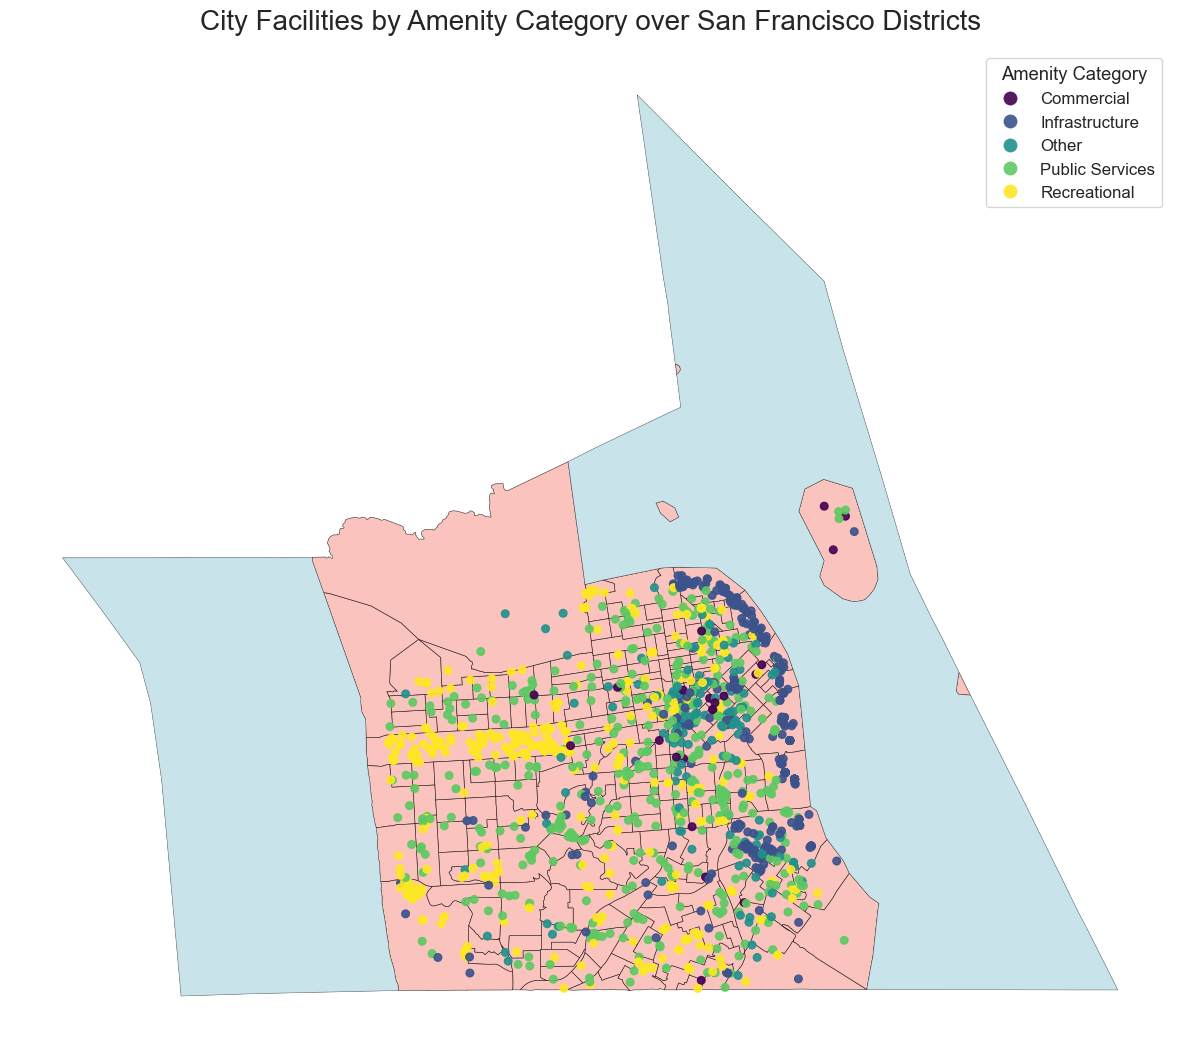

In [100]:
# plot with shaded polygons by district
fig, ax = plt.subplots(figsize=(12, 12))

# plot shaded tracts by district (light colormap)
sf_tracts.plot(
    ax=ax,
    column="district",
    cmap="Pastel1",
    edgecolor="black",
    linewidth=0.4,
    legend=True,
    alpha=0.8,
)

# highlight water/non-SF tracts separately in gray
sf_tracts[sf_tracts["district"] == "Water / Non-SF"].plot(
    ax=ax, color="lightblue", edgecolor="none", alpha=0.6
)

# plot city facilities on top
city_facilities_sf.plot(
    ax=ax,
    column="amenity_category",
    categorical=True,
    cmap="viridis", #tab10
    legend=True,
    markersize=30,
    alpha=0.9,
)

# style the plot
ax.set_title(
    "City Facilities by Amenity Category over San Francisco Districts",
    fontsize=20,
    pad=15,
)

# move the legend to the side
leg = ax.get_legend()
if leg:
    #leg.set_bbox_to_anchor((1.3, 0.5))  # play around for better aesthetics
    leg.set_title("Amenity Category")

ax.set_axis_off()
plt.tight_layout()
plt.show()

In [101]:
# drop data/time related columns to use .explore/folium for interactive mapping later
city_facilities_sf_nodatetime = city_facilities_sf.drop(columns=['data_last_updated', 'data_as_of', 'data_loaded_at', ':created_at', ':updated_at'])

Create interactive html map and save it in the visualizations folder:

In [102]:
# base map showing shaded polygons by district
m = sf_tracts.explore(
    column="district",
    cmap="Pastel1",
    legend=True,
    style_kwds={"fillOpacity": 0.6, "weight": 0.4, "color": "black"},
    name="SF Districts",
)

# add water/non-SF tracts in light blue
sf_tracts[sf_tracts["district"] == "Water / Non-SF"].explore(
    m=m,
    color="lightblue",
    style_kwds={"fillOpacity": 0.6, "weight": 0},
    name="Water / Non-SF",
)

# add city facilities on top, colored by amenity category
city_facilities_sf_nodatetime.explore(
    m=m,
    column="amenity_category",
    cmap="viridis",
    legend=True,
    marker_kwds={"radius": 6, "fill": True, "fillOpacity": 0.9},
    name="City Facilities",
)

# add layer control
folium.LayerControl().add_to(m)

# m --> can't display directly in notebook (because Jupyter on VS code has issue with Trust Notebook), so save to HTML

# save to the visualizations folder instead
m.save(str(repo_root / 'visualizations' / 'city_facilities_map.html'))


#### Clean Data, focusing on `gross_sq_ft`

In [103]:
# check the dataframe structure
city_facilities_sf_nodatetime.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 1444 entries, 2 to 1732
Data columns (total 43 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   :id                          1444 non-null   object  
 1   :version                     1444 non-null   object  
 2   facility_id                  1444 non-null   object  
 3   common_name                  1444 non-null   object  
 4   address                      1444 non-null   object  
 5   city                         1444 non-null   object  
 6   zip_code                     1444 non-null   object  
 7   block_lot                    1339 non-null   object  
 8   owned_leased                 1444 non-null   object  
 9   dept_id                      1444 non-null   object  
 10  department_name              1444 non-null   object  
 11  gross_sq_ft                  834 non-null    object  
 12  longitude                    1444 non-null   object  
 13  

In [104]:
# convert gross_sq_ft to numeric, coerce errors to NaN, being mindfull of commas
city_facilities_sf_nodatetime['gross_sq_ft'] = pd.to_numeric(
    city_facilities_sf_nodatetime['gross_sq_ft'].str.replace(',', '', regex=False),
    errors='coerce'
)

# describe numeric columns to check for anomalies
city_facilities_sf_nodatetime.describe(include=[np.number])

,gross_sq_ft,index_right,ALAND,AWATER
count,8.340000e+02,1444.000000,1.444000e+03,1.444000e+03
mean,4.169762e+04,5592.270776,1.474490e+06,3.841810e+05
std,1.159119e+05,2041.759451,1.563229e+06,1.492194e+06
min,0.000000e+00,341.000000,2.629500e+04,0.000000e+00
25%,1.836000e+03,3717.000000,3.362290e+05,0.000000e+00
50%,8.441500e+03,6342.000000,6.760890e+05,4.369000e+03
75%,3.362925e+04,6720.000000,2.096514e+06,4.094660e+05
max,2.120275e+06,8933.000000,6.126570e+06,2.032812e+07


In [105]:
# join the updated Parks and Recreation gross_sq_ft and data changes from "data/raw/parks_and_rec_joined.geojson"
parks_rec_update_path = repo_root / "data" / "processed" / "parks_and_rec_joined.geojson"
parks_rec_update = gpd.read_file(parks_rec_update_path, engine="pyogrio")   

# Select only Recreation And Parks rows in city_facilities
mask = city_facilities_sf_nodatetime['department_name'] == 'Recreation And Parks'
parks_facilities = city_facilities_sf_nodatetime[mask].copy()

# Merge with the updated parks data on 'address' and 'common_name'
updated_merge = parks_facilities.merge(
    parks_rec_update[['address', 'common_name', 'gross_sq_ft']],
    on=['address', 'common_name'],
    how='left',
    suffixes=('', '_new')
)

# Update gross_sq_ft: use the new value if it exists, otherwise keep original
updated_merge['gross_sq_ft'] = updated_merge['gross_sq_ft_new'].combine_first(updated_merge['gross_sq_ft'])


# Drop the temporary column
updated_merge = updated_merge.drop(columns=['gross_sq_ft_new'])

# Put updated rows back into the original GeoDataFrame
city_facilities_sf_nodatetime.loc[mask, 'gross_sq_ft'] = updated_merge['gross_sq_ft'].values

city_facilities_sf_nodatetime.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 1444 entries, 2 to 1732
Data columns (total 43 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   :id                          1444 non-null   object  
 1   :version                     1444 non-null   object  
 2   facility_id                  1444 non-null   object  
 3   common_name                  1444 non-null   object  
 4   address                      1444 non-null   object  
 5   city                         1444 non-null   object  
 6   zip_code                     1444 non-null   object  
 7   block_lot                    1339 non-null   object  
 8   owned_leased                 1444 non-null   object  
 9   dept_id                      1444 non-null   object  
 10  department_name              1444 non-null   object  
 11  gross_sq_ft                  986 non-null    float64 
 12  longitude                    1444 non-null   object  
 13  

Explore the rows with missing `gross_sq_ft` values:

In [106]:
# explore how many of the gross_sq_ft values are still missing for each amenity category
city_facilities_sf_nodatetime[city_facilities_sf_nodatetime['gross_sq_ft'].isna()]['amenity_category'].value_counts() 

amenity_category
Infrastructure     134
Other              124
Public Services    111
Recreational        70
Commercial          19
Name: count, dtype: int64

In [107]:
# summary of missing gross_sq_ft for selected amenity categories
categories = ["Infrastructure", "Other", "Public Services"]
city_facilities_sf_nodatetime.groupby("amenity_category")[["facility_id"]].agg("count")

,facility_id
amenity_category,
Commercial,25
Infrastructure,368
Other,127
Public Services,457
Recreational,467


Based on the previous 2 outputs, it seems that the majority of the Other category (124/127) has missing `gross_sq_ft`. We've already handled the missing data for the Recreational category in the other notebook. For the Commercial category, 19/25 rows don't have `gross_sq_ft` possibly because they are private, small, or more recent/renovated recently. For Infrastructure, about a third of the data is missing, and for Public Services, about a fourth is missing. Since these 2 are larger categories, I'll explore wehther we can interpolate the data in some way.

In [108]:
# from insights from the Recreation_Parks_Data_Clean_Analysis.ipynb:
# fill with 1st quantile of Recreational gross_sq_ft values = 500.0

mask = (city_facilities_sf_nodatetime['gross_sq_ft'].isna()) & (city_facilities_sf_nodatetime['amenity_category'] == 'Recreational')
q1 = city_facilities_sf_nodatetime.loc[city_facilities_sf_nodatetime['amenity_category'] == 'Recreational', 'gross_sq_ft'].quantile(0.25)
city_facilities_sf_nodatetime.loc[mask, 'gross_sq_ft'] = q1
# quick check to see that there are no more NaNs in Recreational category
city_facilities_sf_nodatetime[city_facilities_sf_nodatetime['gross_sq_ft'].isna()]['amenity_category'].value_counts() 

amenity_category
Infrastructure     134
Other              124
Public Services    111
Commercial          19
Name: count, dtype: int64

In [109]:
# look at the types of department_type, addresses and common_names of Other amenity column since it seems a majority of them have missing gross_sq_ft
# city_facilities_sf_nodatetime[(city_facilities_sf_nodatetime['gross_sq_ft'].isna()) & (city_facilities_sf_nodatetime['amenity_category'] == 'Other')]
city_facilities_sf_nodatetime[city_facilities_sf_nodatetime['amenity_category'] == 'Other'][["facility_id", "department_name", "address", "common_name", "gross_sq_ft"]].head(10)

,facility_id,department_name,address,common_name,gross_sq_ft
52,3238,Gsa - Office Of Contract Administration,555 Selby St,Central Shops - 555 Selby St,56814.0
119,1007,Non-City,1315-1319 Evans Ave,1315-1319 Evans Ave,NaN
425,3508,Non-City,125 Bay Shore Blvd,125 Bay Shore Blvd Building,NaN
494,3239,Non-City,450 Toland St,450 Toland St,NaN
516,3496,Non-City,1925 Evans Ave,1925 Evans Ave Navigation Center,NaN
616,3471,Non-City,1305 Evans Ave,1305-1309 Evans Ave,NaN
826,763,Gsa - Medical Examiner,1 Newhall St,Office of the Chief Medical Examiner Building,46000.0
832,451,Gsa - Office Of Contract Administration,1800 Jerrold Ave,Central Shops,NaN
913,3470,Non-City,Napoleon St and Evans Ave,Caltrans I-280 (Napoleon/Evans),NaN
991,3335,Non-City,2025 Newcomb,Material Testing Lab - 2025 Newcomb,NaN


After viewing some of these locations in Google Maps, we can remove them as they don't fall under our definition of amenities. Some of these seem to be government buildings, Non-city/non-public properties, or other establishments that don't fall under the scope of this project. Therefore, I will drop this column.

In [110]:
# drop the Other amenity category as they don't fall under our definition of amenities
drop_mask = city_facilities_sf_nodatetime['amenity_category'] == 'Other'    
city_facilities_sf_nodatetime = city_facilities_sf_nodatetime[~drop_mask].copy()

In [111]:
# look at the Commerical categories rows
city_facilities_sf_nodatetime[city_facilities_sf_nodatetime['amenity_category'] == 'Commercial'][["facility_id", "department_name", "address", "common_name", "gross_sq_ft"]]

,facility_id,department_name,address,common_name,gross_sq_ft
524,141,Mayor,155 Grove St,155-165 Grove St,4186.0
775,273,Mayor,240 Van Ness Ave,240 Van Ness Ave Building,15950.0
1398,3158,Mayor,1415 Scott St,MIDTOWN PARK APARTMENTS,NaN
26,2029,Mayor,1294-8 Shotwell St,1294-8 Shotwell St - Future MOH Housing Site,NaN
29,3301,Treasure Island Development Authority,Ave M & 8TH TI ST,TI Athletic Field - 8TH/AVE M,NaN
90,3167,Treasure Island Development Authority,401 13TH ST,Building 33 - Treasure Island,10604.0
1295,3302,Treasure Island Development Authority,1 Avenue of the Palms,1 Ave of the Palms Building,4052.0
1706,3511,Mayor,280 Beale St,280 Beale St Housing,NaN
242,3500,Mayor,227 7th St,Westbrook Garage,NaN
492,3505,Mayor,921 Howard St,921 Howard St,NaN


Since there are only 25 rows for the Commercial category, I noticed that the Treasure Island columns could be dropped as that location doesn't exist in Google Maps anymore. Moreover, the remaining "Mayor" department values look like mainly housing complexes (like appartments) and a few other things like Senior Centers or Garages. For this I'll interpolate the data with the mean of the exisiting Mayor category since Housing complexes should roughly be around the same size. I'll be noting this assumption in our `report.pdf` as well.

In [112]:
# remove Treasure Island address Ave M & 8TH TI ST because it doesn't exist in Google Maps anymore
ti_mask = city_facilities_sf_nodatetime['address'].str.contains('Ave M & 8TH TI ST', na=False)
city_facilities_sf_nodatetime = city_facilities_sf_nodatetime[~ti_mask].copy()

# interpolate remaining missing Commercial gross_sq_ft with mean of existing Mayor category values
mayor_mean = city_facilities_sf_nodatetime.loc[
    (city_facilities_sf_nodatetime['department_name'] == 'Mayor') &   (city_facilities_sf_nodatetime['gross_sq_ft'].notna()),
    'gross_sq_ft'
].mean()

mask = (city_facilities_sf_nodatetime['gross_sq_ft'].isna()) & (city_facilities_sf_nodatetime['department_name'] == 'Mayor')
city_facilities_sf_nodatetime.loc[mask, 'gross_sq_ft'] = mayor_mean

Now, I'll look into the missing `gross_sq_ft` data in the Infrastructure and Public Services categories.

In [113]:
# look at remaining missing gross_sq_ft values

display(city_facilities_sf_nodatetime[(city_facilities_sf_nodatetime['gross_sq_ft'].isna()) & (city_facilities_sf_nodatetime['amenity_category'] == 'Infrastructure')][["facility_id", "amenity_category", "department_name", "address", "common_name", "gross_sq_ft"]].head(5))
display(city_facilities_sf_nodatetime[(city_facilities_sf_nodatetime['gross_sq_ft'].isna()) & (city_facilities_sf_nodatetime['amenity_category'] == 'Public Services')][["facility_id", "amenity_category", "department_name", "address", "common_name", "gross_sq_ft"]].head(5))

# look at the breakdown of department_name for missing Infrastructure and Public Services gross_sq_ft
display(city_facilities_sf_nodatetime[(city_facilities_sf_nodatetime['amenity_category'] == 'Infrastructure')]['department_name'].value_counts())
display(city_facilities_sf_nodatetime[(city_facilities_sf_nodatetime['gross_sq_ft'].isna()) & (city_facilities_sf_nodatetime['amenity_category'] == 'Infrastructure')]['department_name'].value_counts())
display(city_facilities_sf_nodatetime[(city_facilities_sf_nodatetime['amenity_category'] == 'Public Services')]['department_name'].value_counts())
display(city_facilities_sf_nodatetime[(city_facilities_sf_nodatetime['gross_sq_ft'].isna()) & (city_facilities_sf_nodatetime['amenity_category'] == 'Public Services')]['department_name'].value_counts())

,facility_id,amenity_category,department_name,address,common_name,gross_sq_ft
2,3199,Infrastructure,Public Utilities Commission,1800 Oakdale Ave,SE CENTRIFUGAL BLDG - 840,NaN
32,3181,Infrastructure,Public Utilities Commission,1700 Jerrold Ave,SE SED BLDG #3 042,NaN
37,3187,Infrastructure,Public Utilities Commission,1700 Jerrold Ave,SE D. SLUDGE THK. TANK - 750,NaN
105,3208,Infrastructure,Public Works,2323 Cesar Chavez St,"DPW - Carport 4-G,H,J",NaN
147,3188,Infrastructure,Public Utilities Commission,1700 Jerrold Ave,SE SLUDGE FILTRATION -790,NaN


,facility_id,amenity_category,department_name,address,common_name,gross_sq_ft
286,2060,Public Services,Municipal Transportation Agency,1301 Cesar Chavez St,Islais Creek Facility,NaN
575,1175,Public Services,Municipal Transportation Agency,400 Cesar Chavez St,Muni Warehouse,NaN
831,1574,Public Services,School District (Sfusd),801 Toland St,SFUSD -- Warehouse/Transportation,NaN
1109,1171,Public Services,Municipal Transportation Agency,1500 Illinois St,Muni Trailer - 1500 Illinois St,NaN
1340,3007,Public Services,Municipal Transportation Agency,601 25th St,MICHIGAN (DC SUB - Line),NaN


department_name
Port                                      213
Public Utilities Commission                70
Gsa - Real Estate Division                 57
Public Works                               23
Gsa - Convention Facilities Management      4
Technology                                  1
Name: count, dtype: int64

department_name
Public Utilities Commission    62
Port                           40
Gsa - Real Estate Division     20
Public Works                   12
Name: count, dtype: int64

department_name
School District (Sfusd)                155
Municipal Transportation Agency        127
Fire Department                         57
Public Health                           41
Public Library                          29
Police Department                       21
Juvenile Probation                      11
Human Services Agency                    8
Homelessness And Supportive Housing      5
Sheriff                                  2
Superior Court                           1
Name: count, dtype: int64

department_name
School District (Sfusd)                40
Public Health                          21
Municipal Transportation Agency        20
Juvenile Probation                     10
Fire Department                         9
Police Department                       6
Homelessness And Supportive Housing     4
Human Services Agency                   1
Name: count, dtype: int64

For both these categories, I'll interpolate the missing data using the medians of the existing values for each department. I've also looked at a few of the addressees on Google Maps first and they seem to match the characteristics of the rows with data for `gross_sq_ft`. We are choosing to take the medians rather than the means or other values to be as robust to outliers as possible. 

In [114]:
# fill in missing Infrastructure and Public Service gross_sq_ft with median values by department_name
for category in ['Infrastructure', 'Public Services']:
    dept_names = city_facilities_sf_nodatetime.loc[
        city_facilities_sf_nodatetime['amenity_category'] == category, 'department_name'
    ].unique()
    
    for dept in dept_names:
        median_value = city_facilities_sf_nodatetime.loc[
            (city_facilities_sf_nodatetime['amenity_category'] == category) & 
            (city_facilities_sf_nodatetime['department_name'] == dept) & 
            (city_facilities_sf_nodatetime['gross_sq_ft'].notna()),
            'gross_sq_ft'
        ].median()
        
        mask = (
            (city_facilities_sf_nodatetime['amenity_category'] == category) & 
            (city_facilities_sf_nodatetime['department_name'] == dept) & 
            (city_facilities_sf_nodatetime['gross_sq_ft'].isna())
        )
        
        city_facilities_sf_nodatetime.loc[mask, 'gross_sq_ft'] = median_value

# final check for any remaining missing gross_sq_ft values
print(np.mean(city_facilities_sf_nodatetime['gross_sq_ft'].isna())) # should be 0.0 if all missing values have been filled

0.0


In [ ]:
# save the cleaned data to processed folder
output_path = repo_root / "data" / "processed" / "city_facilities_cleaned.geojson"
city_facilities_sf_nodatetime.to_file(output_path, driver="GeoJSON", engine="pyogrio")

#### Data Visualization on `gross_sq_ft`

Initial visualization of `gross_sq_ft` column now that there are no missing values. I'll start with just a simple histogram of the `gross_sq_ft` and since that distribution is very right skewed, I'll add a log transformation to it.

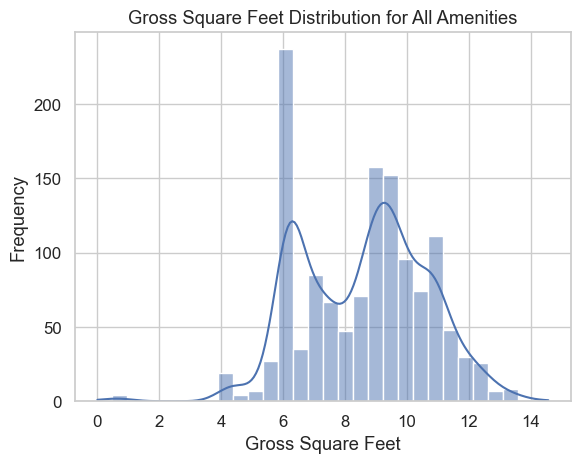

In [115]:
# analyze the gross_sq_ft distribution after for each amenity category
sns.histplot(np.log1p(city_facilities_sf_nodatetime['gross_sq_ft']), bins=30, kde=True)
plt.title(f'Gross Square Feet Distribution for All Amenities')
plt.xlabel('Gross Square Feet')
plt.ylabel('Frequency')
plt.show()
    

Now I'll make a box plot for each of the Amenity categories.

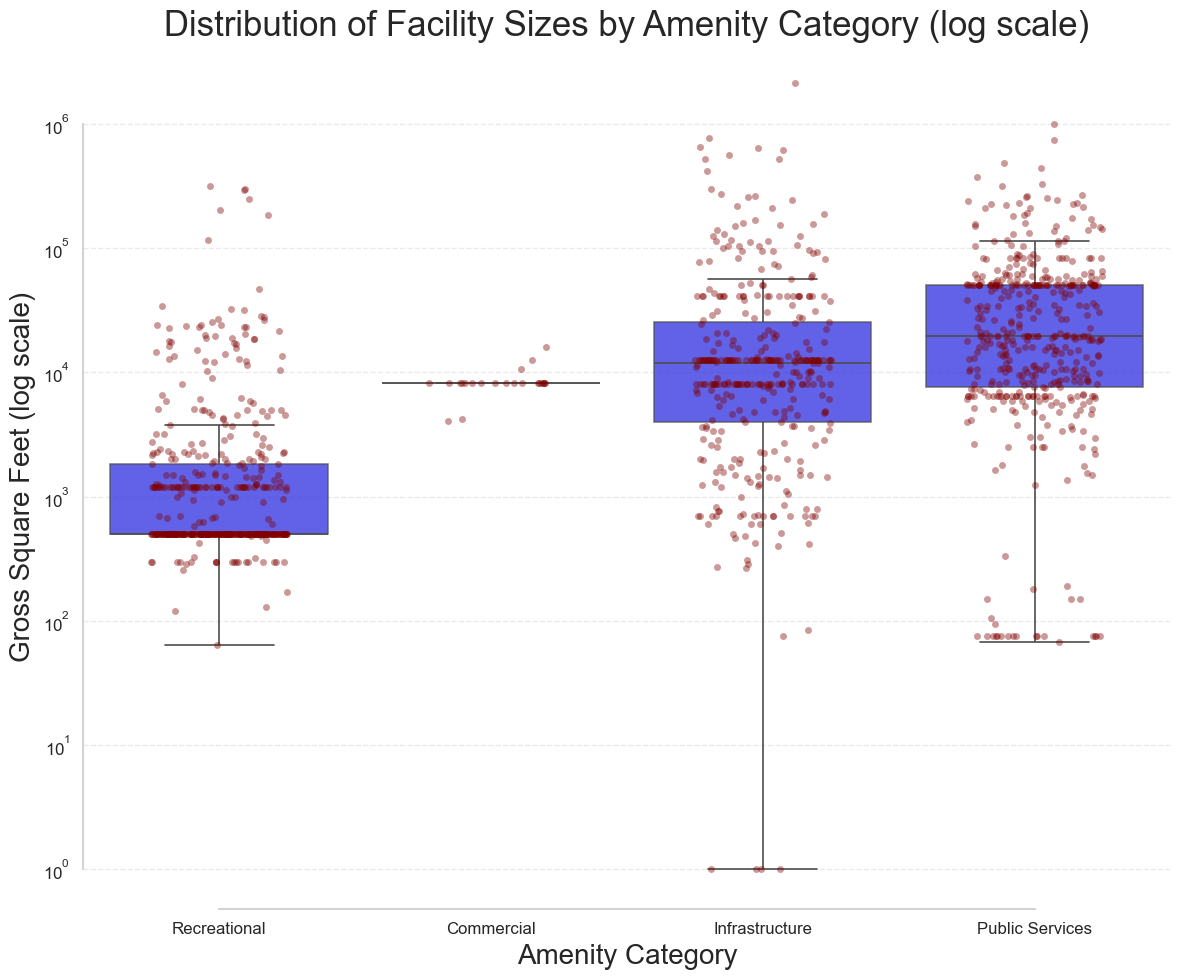

In [116]:
# plot size in inches
plt.figure(figsize=(12, 10))

# sorted categories by median gross_sq_ft (helps readability)
order = (
    city_facilities_sf_nodatetime
    .groupby("amenity_category")["gross_sq_ft"]
    .median()
    .sort_values()
    .index
)

# create the boxplot
sns.boxplot(
    data=city_facilities_sf_nodatetime,
    x="amenity_category",
    y="gross_sq_ft",
    order=order,
    color = "blue",
    showfliers=False,              # hide outliers for cleaner look
    linewidth=1.2,
    boxprops=dict(alpha=0.7)       # slightly transparent for easier overlaying of stripplot
)

# overlay stripplot (optional: shows individual data points as well)
sns.stripplot(
    data=city_facilities_sf_nodatetime,
    x="amenity_category",
    y="gross_sq_ft",
    order=order,
    color="maroon",
    alpha=0.4,
    size=5,
    jitter=0.25
)

# use log scale for y-axis
plt.yscale("log")

# improve labels and layout
plt.title("Distribution of Facility Sizes by Amenity Category (log scale)", fontsize=25)
plt.xlabel("Amenity Category", fontsize=20, labelpad=5)
plt.ylabel("Gross Square Feet (log scale)", fontsize=20, labelpad=5)

# light grid for readability
sns.despine(trim=True)
plt.grid(axis="y", linestyle="--", alpha=0.4)

# save plot to visualizations folder
plt.savefig(repo_root / 'visualizations' / 'gross_sq_ft_boxplot_by_amenity_category.png', dpi=300)

plt.tight_layout()
plt.show()


I'll now create a chloropleth map to understand the distribution of total `gross_sq_ft` of different amenity types across census tracts.

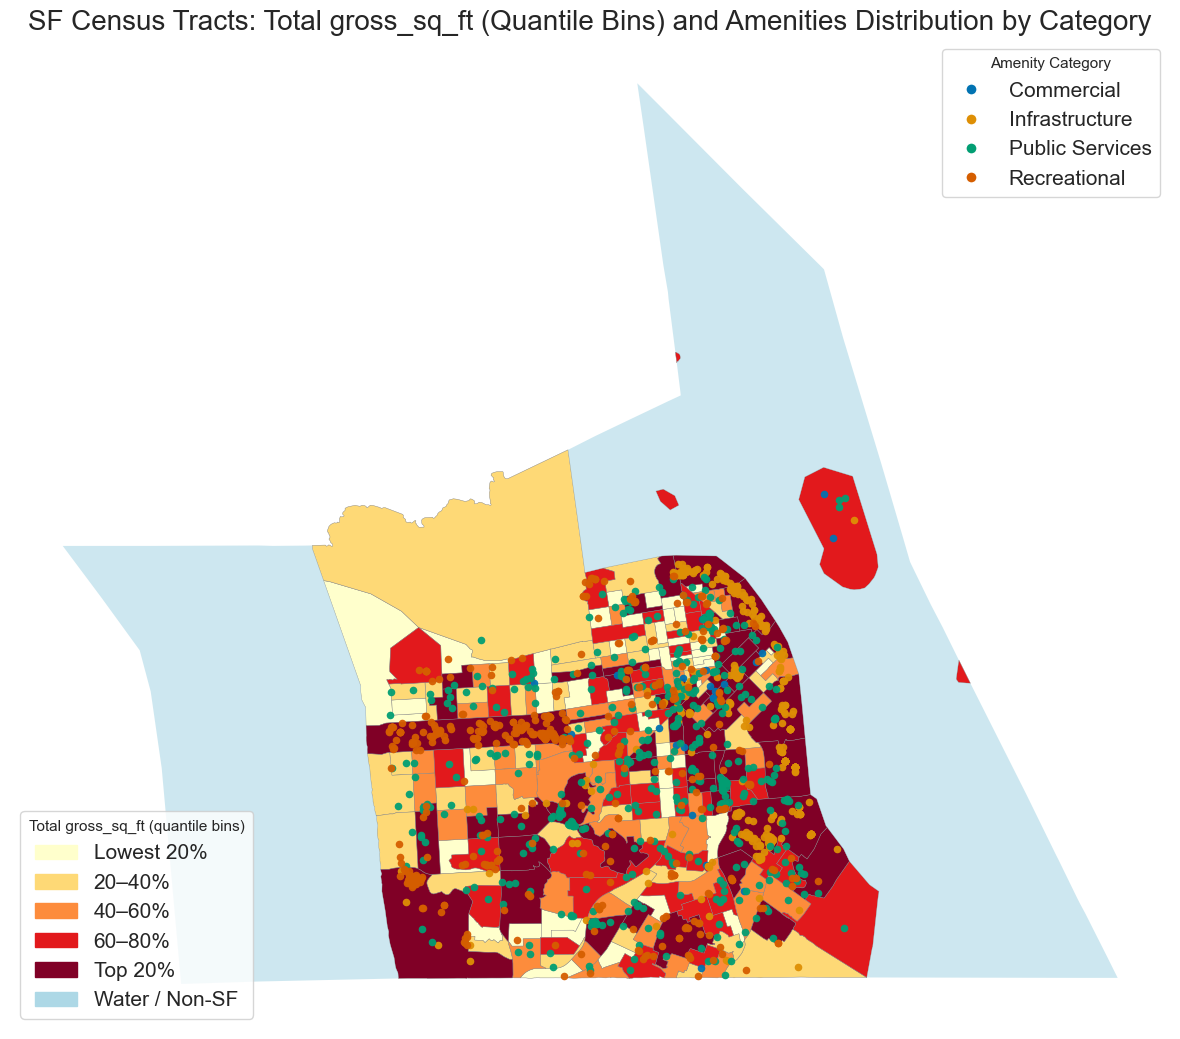

In [126]:
# initialize plot, with improved legend handling
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# land polygons (exclude water)
land = tracts_choro[~tracts_choro["is_water"].fillna(False)].copy()

# ensure sqft_bin is categorical with desired ordered labels
if 'sqft_bin' not in land.columns or land['sqft_bin'].isna().all():
    # fallback: create quintile bins if missing
    land['sqft_bin'] = pd.qcut(land['total_sqft'].fillna(0).astype(float), q=5,
                               labels=["Lowest 20%", "20–40%", "40–60%", "60–80%", "Top 20%"],
                               duplicates='drop')
categories = list(land['sqft_bin'].cat.categories) if pd.api.types.is_categorical_dtype(land['sqft_bin']) else sorted(land['sqft_bin'].dropna().unique())

# discrete colormap for the bins (use new API to avoid deprecation)
n_bins = max(1, len(categories))
cmap = mpl.colormaps.get_cmap("YlOrRd")  # fixes deprecation warning
# sample n_bins colors and convert to hex for consistent plotting/legend
bin_colors = [mpl.colors.to_hex(c) for c in cmap(np.linspace(0, 1, n_bins))]

# plot each bin explicitly so we can make legend handles
poly_handles = []
for i, cat in enumerate(categories):
    subset = land[land['sqft_bin'] == cat]
    color_hex = bin_colors[i] if i < len(bin_colors) else "#cccccc"
    if subset.empty:
        poly_handles.append(mpatches.Patch(color=color_hex, label=str(cat)))
        continue
    subset.plot(ax=ax, color=color_hex, edgecolor='gray', linewidth=0.3)
    poly_handles.append(mpatches.Patch(color=color_hex, label=str(cat)))

# plot water / non-SF
water = tracts_choro[tracts_choro["is_water"].fillna(False)]
water_handle = None
if not water.empty:
    water.plot(ax=ax, color="lightblue", edgecolor="none", alpha=0.6)
    water_handle = mpatches.Patch(color="lightblue", label="Water / Non-SF")

# Amenity points: use a colorblind-friendly qualitative palette (contrasts with YlOrRd)
amen_cats = sorted(city_facilities_sf_nodatetime['amenity_category'].dropna().unique())
# get a colorblind-friendly palette sized to number of categories
amen_pal = sns.color_palette("colorblind", n_colors=max(3, len(amen_cats)))
amen_colors = [mpl.colors.to_hex(c) for c in amen_pal]

point_handles = []
for i, cat in enumerate(amen_cats):
    subset = city_facilities_sf_nodatetime[city_facilities_sf_nodatetime['amenity_category'] == cat]
    color = amen_colors[i % len(amen_colors)]
    if not subset.empty:
        subset.plot(ax=ax, color=color, markersize=30, label=str(cat), alpha=0.95, marker='o', linewidth=0)
    # legend handle for amenity category
    point_handles.append(Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=8, label=str(cat)))

# Create polygon legend (bins + optional water)
legend_polys = poly_handles.copy()
if water_handle is not None:
    legend_polys.append(water_handle)

# place legends: polygons lower-left, points upper-right
if legend_polys:
    leg1 = ax.legend(handles=legend_polys, title="Total gross_sq_ft (quantile bins)", loc='lower left', frameon=True, fontsize=15, title_fontsize=11)
    ax.add_artist(leg1)

if point_handles:
    ax.legend(handles=point_handles, title="Amenity Category", loc='upper right', frameon=True, fontsize=15, title_fontsize=11)

# title and style
ax.set_title("SF Census Tracts: Total gross_sq_ft (Quantile Bins) and Amenities Distribution by Category", fontsize=20)
ax.set_axis_off()
plt.tight_layout()

# save plot
plt.savefig(repo_root / 'visualizations' / 'tracts_gross_sqft_amenities_choropleth.png', dpi=300)
plt.show()